In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import plot_confusion_matrix 
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Imputer, QuantileDiscretizer
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


In [0]:
def metricsCalculated(predictions, modelName) :
  print("%s : " % modelName)
  results = predictions.select(['prediction', 'label'])
  count = predictions.count()

  correctlyClassified = results.filter(results.prediction == results.label).count()
  incorrectlyClassified = results.filter(results.prediction != results.label).count()

#   truePositive  = results.filter(results.prediction == 1.0).filter(results.prediction == results.label).count()
#   falsePositive = results.filter(results.prediction == 1.0).filter(results.prediction != results.label).count()
#   falseNegative = results.filter(results.prediction == 0.0).filter(results.prediction != results.label).count()
#   trueNegative  = results.filter(results.prediction == 0.0).filter(results.prediction == results.label).count()

## Yet Another way of calculating TP, FP, FN, TN
  trueNegative = predictions.filter('prediction = 0 AND label = prediction').count()
  truePositive = predictions.filter('prediction = 1 AND label = prediction').count()
  falseNegative = predictions.filter('prediction = 0 AND label != prediction').count()
  falsePositive = predictions.filter('prediction = 1 AND label != prediction').count()  
  
  accuracy  = (truePositive + trueNegative)/count
  precision = truePositive/(truePositive + falsePositive)
  recall    = truePositive/(truePositive + falseNegative)

  print("%s\nCorrectly Classified: %s\nIncorrectly Classified: %s\nTrue Positive: %s\nFalse Positive: %s\nTrue Negative: %s\nFalse Negative: %s\nAccuracy: %s\nPrecision: %s\nRecall: %s" % (modelName, correctlyClassified, incorrectlyClassified, truePositive, falsePositive, trueNegative, falseNegative, accuracy, precision, recall))

## A more simpler way of getting TP[0], FP[1], FN[2], TN[3] in one single line 
##  predictions.groupBy("label", "prediction").count().show()

## Yet Another way of calculating TP, FP, FN, TN
##  trueNegative = prediction.filter('prediction = 0 AND label = prediction').count()
##  truePositive = prediction.filter('prediction = 1 AND label = prediction').count()
##  falseNegative = prediction.filter('prediction = 0 AND label != prediction').count()
##  falsePositive = prediction.filter('prediction = 1 AND label != prediction').count()

  evaluation(predictions, modelName)

In [0]:
# File location and type
file_location = "/FileStore/shared_uploads/deshmukhv@coventry.ac.uk/TelcoCustomerChurn.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
customerChurn = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .option('nanValue', ' ') \
  .option('nullValue', ' ') \
  .load(file_location)

# Shows the first five records
## customerChurn.show(5)


# Have a look at the data
display(customerChurn)


customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes
9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.1,1949.4,No
6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.8,3046.05,Yes
6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [0]:
# What are the datatypes of each column --using dtypes attribute of spark DF
# customerChurn.dtypes

# What are the datatypes of each column --using printSchema method of spark DF
customerChurn.printSchema()


root
-- customerID: string (nullable = true)
-- gender: string (nullable = true)
-- SeniorCitizen: integer (nullable = true)
-- Partner: string (nullable = true)
-- Dependents: string (nullable = true)
-- tenure: integer (nullable = true)
-- PhoneService: string (nullable = true)
-- MultipleLines: string (nullable = true)
-- InternetService: string (nullable = true)
-- OnlineSecurity: string (nullable = true)
-- OnlineBackup: string (nullable = true)
-- DeviceProtection: string (nullable = true)
-- TechSupport: string (nullable = true)
-- StreamingTV: string (nullable = true)
-- StreamingMovies: string (nullable = true)
-- Contract: string (nullable = true)
-- PaperlessBilling: string (nullable = true)
-- PaymentMethod: string (nullable = true)
-- MonthlyCharges: double (nullable = true)
-- TotalCharges: double (nullable = true)
-- Churn: string (nullable = true)

In [0]:
# Check which columns have null/nan values and their count
# display(customerChurn.select([count( when( isnan( column ) | col( column ).isNull(), column )).alias(column) for column in customerChurn.columns]))

# Check which columns have null/nan values and their count
customerChurn.select([count( when( isnan( column ) | col( column ).isNull(), column )).alias(column) for column in customerChurn.columns]).show()

# dataframe.dropna() method could be used to drop null values from any columns that contain it.
# It basically would delete the entire row
## customerChurn.dropna()

# dataframe.withColumn could be used to add new column or mutate an existing one.
## customerChurn.withColumn("TotalCharges", round(customerChurn.TotalCharges / customerChurn.TotalCharges.mean, 0))

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 11| 0|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+

In [0]:
# Get the data from Spark Dataframe to Pandas Dataframe
# Warning : should not be tried out with Huge dataset. How Huge ? As much as the driver node's memory
customerChurn_pd = customerChurn.toPandas()

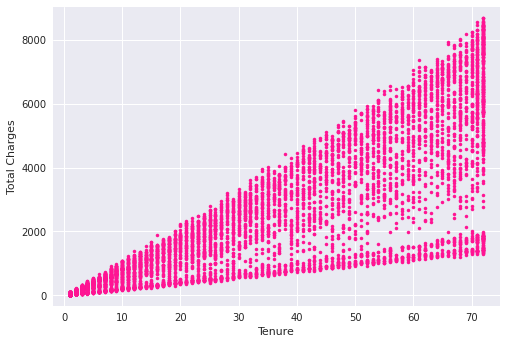

In [0]:
plt.style.use('seaborn')
plt.clf()
plt.plot(customerChurn_pd['tenure'], customerChurn_pd['TotalCharges'], '.', color='deeppink')
plt.xlabel('Tenure')
plt.ylabel('Total Charges')
plt.margins(0.04)
plt.show()

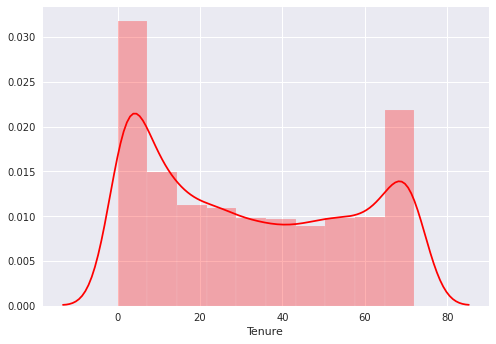

In [0]:
plt.clf()
plt.style.use('seaborn')
# sns.set(style='white')
kwargs = dict(hist_kws={'alpha':0.3})
a = sns.distplot(customerChurn_pd.tenure, 10, color='red',axlabel='Tenure', **kwargs)
# a.set_xticks(range(0,80,10))
# plt.xlim(-10, 80)
# sns.kdeplot(customerChurn_pd.tenure, shade=True, color='r', )
# plt.hist(customerChurn_pd.tenure, facecolor='red',  alpha=0.50)
plt.show()

Out[97]:

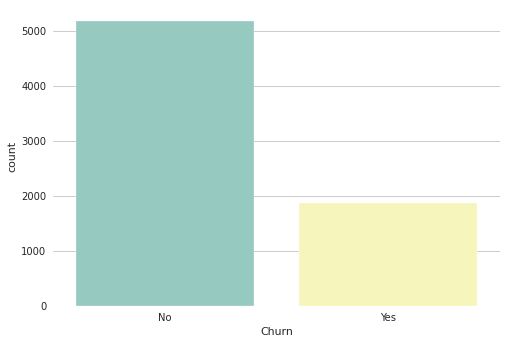

<matplotlib.axes._subplots.AxesSubplot at 0x7fda3325e5e0>

In [0]:
# customerChurn.groupby('Churn').count().show()
# display(customerChurn.groupby('Churn').count())
sns.set_style('whitegrid')
sns.countplot(x=customerChurn_pd.Churn, palette='Set3')


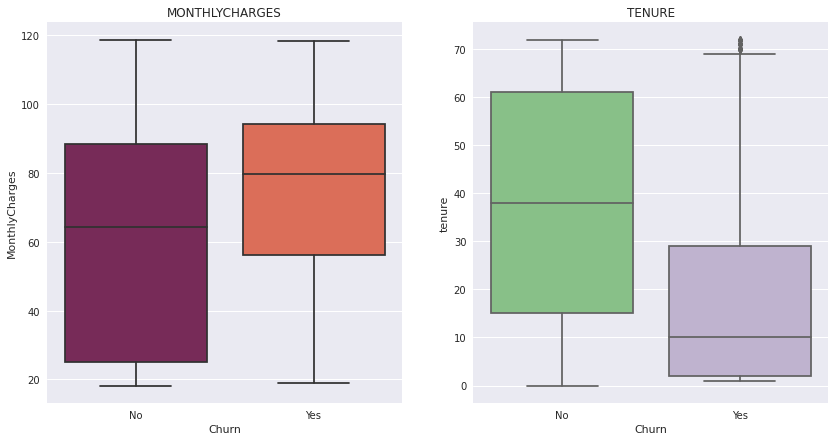

In [0]:
sns.set_style('darkgrid')

def draw_boxplot(x, y, df, rows, columns):
  pallete = ['Accent', 'rocket', 'coolwarm']
  plt.figure(figsize=(7*columns, 7*rows))
  
  for number, columnName in enumerate(y):
    plt.subplot(str(rows) + str(columns) + str(number))
    axis = sns.boxplot(x=x, y=columnName, data=df[[x, columnName]], palette=pallete[number])
    axis.set_title(columnName.upper())
  
  return plt.show()

draw_boxplot("Churn", ["tenure", "MonthlyCharges"], customerChurn_pd, 1, 2)
# plt.figure(figsize=(4,4))
# sns.boxplot( x=customerChurn_pd.Churn, y=customerChurn_pd.tenure, color='r', palette='Set3', width=0.5 )
# plt.set_title()
# sns.boxplot( x=customerChurn_pd.Churn, y=customerChurn_pd.tenure, color='r', palette='Set3', width=0.5 )

In [0]:
def draw_countplot(x, y, df, rows, columns):
#   pallete = ['Accent', 'rocket', 'coolwarm']
  sns.set_style('whitegrid')
  pallete = ['coolwarm', 'GnBu', 'Accent', 'Pastel2', 'inferno', 'Greys']
  plt.figure(figsize=(10*columns, 7*rows))
  
  for number, columnName in enumerate(y):
    plt.subplot(str(rows) + str(columns) + str(number+1))
    print(str(rows) + str(columns) + str(number+1))
    axis = sns.countplot(x=columnName, hue=x, data=df, palette=pallete[number])
    axis.set_title(columnName.upper())
  
  return plt.show()

321
322
323
324
325
326

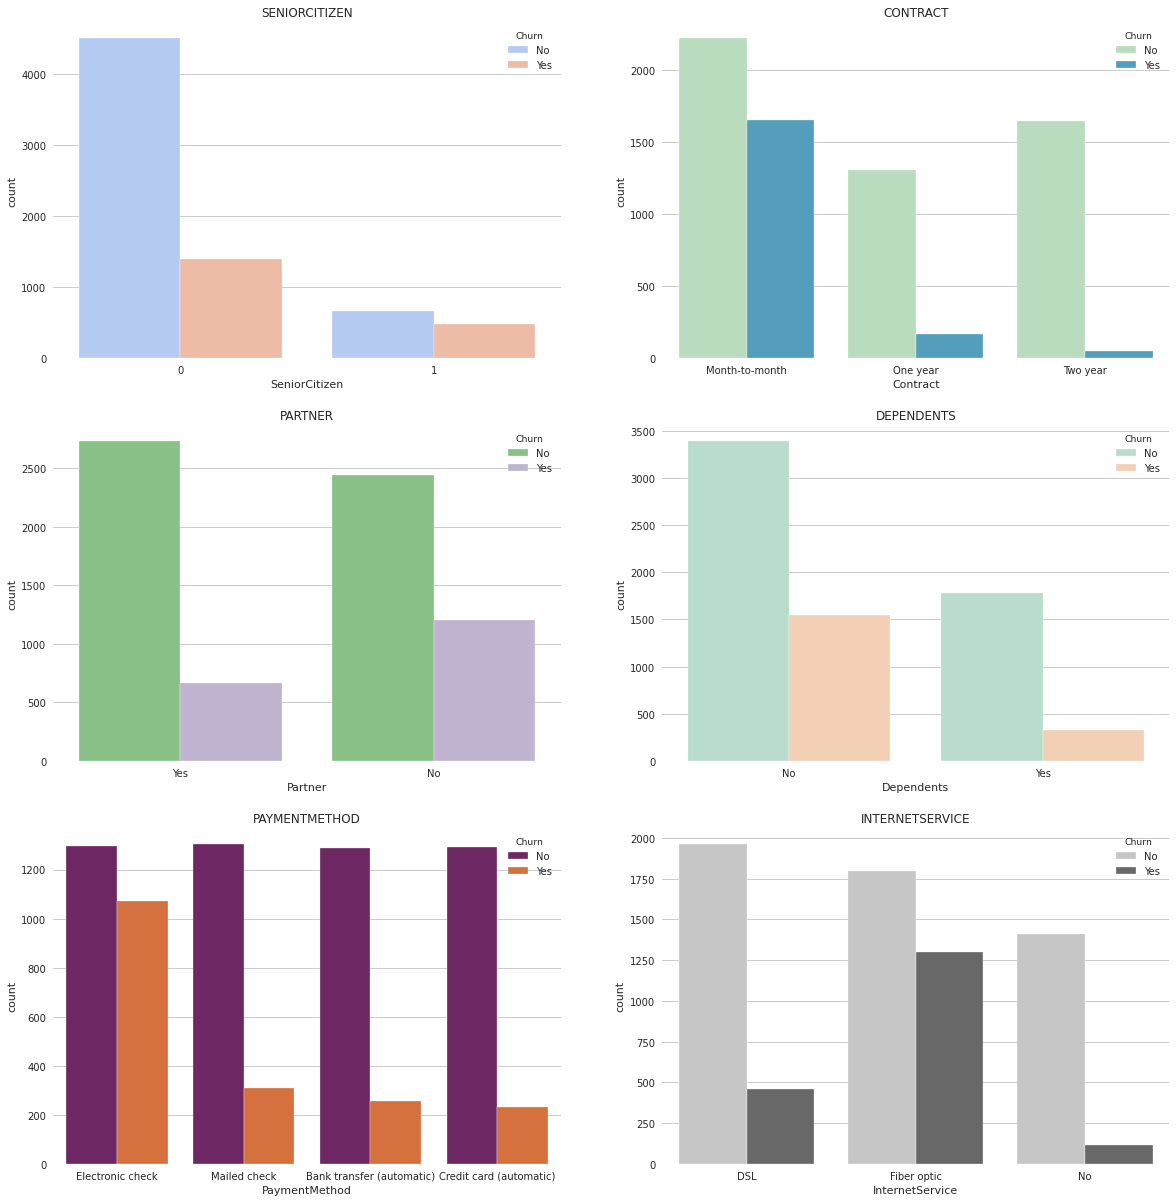

In [0]:
draw_countplot('Churn', ['SeniorCitizen', 'Contract', 'Partner', 'Dependents', 'PaymentMethod', 'InternetService'], customerChurn_pd, 3, 2)

In [0]:
# Create a view or table
temp_table_name = "churnAnalysis"

customerChurn.createOrReplaceTempView(temp_table_name)

In [0]:
%sql
-- Check if Paperless Billing has any effect on churn
select PaperlessBilling, churn, count(churn) from churnAnalysis group by PaperlessBilling, churn

PaperlessBilling,churn,count(churn)
Yes,Yes,1400
No,No,2403
Yes,No,2771
No,Yes,469


In [0]:
%sql
-- Check if Payment Method has any effect on churn
select PaymentMethod, churn, count(churn) from churnAnalysis group by PaymentMethod, churn

PaymentMethod,churn,count(churn)
Credit card (automatic),No,1290
Bank transfer (automatic),No,1286
Mailed check,Yes,308
Credit card (automatic),Yes,232
Electronic check,No,1294
Electronic check,Yes,1071
Bank transfer (automatic),Yes,258
Mailed check,No,1304


In [0]:
%sql
-- Churn based on Customer Tenure
select cast(tenure as int), churn, count(churn) from churnAnalysis group by tenure, churn order by cast(tenure as int)
-- Customers with longer tenure tend to churn less compared to customers with shorter tenure

tenure,churn,count(churn)
0,No,11
1,No,233
1,Yes,380
2,No,115
2,Yes,123
3,No,106
3,Yes,94
4,No,93
4,Yes,83
5,No,69


In [0]:
%sql
select cast(tenure as int), churn, count(*) as churned 
from churnAnalysis 
where churn='Yes' 
group by tenure, churn 
order by cast(tenure as int)

tenure,churn,churned
1,Yes,380
2,Yes,123
3,Yes,94
4,Yes,83
5,Yes,64
6,Yes,40
7,Yes,51
8,Yes,42
9,Yes,46
10,Yes,45


In [0]:
%sql
-- Churn Analysis based on Gender
select gender, churn, count(churn) from churnAnalysis group by gender, churn
-- Get some charts to understand this data better

gender,churn,count(churn)
Male,No,2625
Male,Yes,930
Female,No,2549
Female,Yes,939


In [0]:
%sql
-- Churn based on if customer is a senior citizen
select SeniorCitizen, churn, count(churn) from churnAnalysis group by SeniorCitizen, churn
-- Get some charts to understand this data better

SeniorCitizen,churn,count(churn)
1,No,666
0,No,4508
0,Yes,1393
1,Yes,476


In [0]:
customerChurn.select('tenure', 'TotalCharges', 'MonthlyCharges').describe().show()

# Investigate co-relation between SeniorCitizen and InternetService
customerChurn.stat.crosstab("SeniorCitizen", "InternetService").show()

# Get Most frequent values for each Categorical column
customerChurn.stat.freqItems(["PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"], 0.8).collect()

# Check correlation between TotalCharges and MonthlyCharges
customerChurn.stat.corr('TotalCharges', 'MonthlyCharges')

+-------+------------------+------------------+------------------+
summary| tenure| TotalCharges| MonthlyCharges|
+-------+------------------+------------------+------------------+
 count| 7043| 7032| 7043|
 mean| 32.37114865824223|2283.3004408418697| 64.76169246059922|
 stddev|24.559481023094442| 2266.771361883145|30.090047097678482|
 min| 0| 18.8| 18.25|
 max| 72| 8684.8| 118.75|
+-------+------------------+------------------+------------------+

+-----------------------------+----+-----------+----+
SeniorCitizen_InternetService| DSL|Fiber optic| No|
+-----------------------------+----+-----------+----+
 1| 259| 831| 52|
 0|2162| 2265|1474|
+-----------------------------+----+-----------+----+

Out[102]: 0.6511738315787813

In [0]:
(trainData, testData) = customerChurn.drop("customerID").randomSplit([0.7, 0.3], 96)
print("Records for traning " + str(trainData.count()))
print("Records for testing " + str(testData.count()))
trainData.printSchema()

Records for traning 4948
Records for testing 2095
root
-- gender: string (nullable = true)
-- SeniorCitizen: integer (nullable = true)
-- Partner: string (nullable = true)
-- Dependents: string (nullable = true)
-- tenure: integer (nullable = true)
-- PhoneService: string (nullable = true)
-- MultipleLines: string (nullable = true)
-- InternetService: string (nullable = true)
-- OnlineSecurity: string (nullable = true)
-- OnlineBackup: string (nullable = true)
-- DeviceProtection: string (nullable = true)
-- TechSupport: string (nullable = true)
-- StreamingTV: string (nullable = true)
-- StreamingMovies: string (nullable = true)
-- Contract: string (nullable = true)
-- PaperlessBilling: string (nullable = true)
-- PaymentMethod: string (nullable = true)
-- MonthlyCharges: double (nullable = true)
-- TotalCharges: double (nullable = true)
-- Churn: string (nullable = true)

In [0]:
# Make a list of all Categorical Columns
categoricalColumns = ["gender","SeniorCitizen","Partner","Dependents","PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod"]

# Instantiate String Indexer for all Categorical columns 
# And then OneHotEncode all such String indexed columns
# Append all these stages, later on, we'll fit and transform our data on these.
stages = []

# Convert all values of Categorical columns to numerical indexes
# Create new columns using OneHotEncoder
for column in categoricalColumns:
  sI = StringIndexer(inputCol=column, outputCol=column + "Index")
  oneHE = OneHotEncoder(inputCols = [sI.getOutputCol()], outputCols = [column + "CategoricalVector"])
  
  stages += [sI, oneHE]

# Since TotalCharges column has missing values, impute data in it.   
imputer = Imputer(inputCols=["TotalCharges"], outputCols=["outTotalCharges"])
stages += [imputer]

# Index Label
labelIndex = StringIndexer(inputCol="Churn", outputCol="label")
stages += [labelIndex]

# Check QuantileDiscretizer
# Bins the given column
# Bins are decided based on setNumBuckets
# but can be smaller based on number of distinct values in data
# The bin ranges are decided using approxQuantile algorithm.
tenureBin = QuantileDiscretizer(numBuckets=3, inputCol="tenure", outputCol="tenureBin")
stages += [tenureBin]

# ML Algorithms in Spark operate on a single column
# This column is made up by assembling all other selected input columns 
# VectorAssembler is used to assemble all columns in one final feature column
# this step is added to stages after performing all transformations
numericColumns = ["tenureBin", "outTotalCharges", "MonthlyCharges"]
assembleInputs = assemblerInputs = [c + "CategoricalVector" for c in categoricalColumns] + numericColumns
# print(assembleInputs)
assembler = VectorAssembler(inputCols=assembleInputs, outputCol="features")
stages += [assembler]

In [0]:
# Transform Churn data (Yes, No) to (1, 0)
temp = labelIndex.fit(trainData).transform(trainData)

In [0]:
# Process training data through preprocessing stages
pipeline = Pipeline().setStages(stages)
pipelineModel = pipeline.fit(trainData)
trainPreP = pipelineModel.transform(trainData)

In [0]:
# Preprocess Test Data
testPreP = pipelineModel.transform(testData)

In [0]:
evaluator = BinaryClassificationEvaluator()

In [0]:
def evaluation(predictions, classifierNamer):

# Evaluate Logistic Regression Model
  areaUnderCurve = evaluator.evaluate(predictions)

# AUC 
  print(evaluator.getMetricName())
  print("Area Under ROC: %g" % areaUnderCurve)

# Prediction format
# print(predictions)
# predictions.show(1)

# On which metric was LogReg evaluated


  areaUnderPR = evaluator.evaluate(predictions, {evaluator.metricName:"areaUnderPR"})

# AUPR 
  print("Area Under PR: %g" % areaUnderPR)


# 
# resultsCollect = results.collect()
# resultsList = [(float(i[0]), float(i[1])) for i in resultsCollect] 
# predictionLabels = sc.parallelize(resultsList)
# metrics = BinaryClassificationMetrics(predictionLabels)
# print("Area under PR: %s" % metrics.areaUnderPR)
# print("Area under ROC: %s" % metrics.areaUnderROC)

In [0]:
# Instantiate Logistic Regressions
logReg = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
logRegModel = logReg.fit(trainPreP)

# Check it's parameters
# print("Coefficients: " + str(logRegModel.coefficients))
# print("Intercept: " + str(logRegModel.intercept))

logRegModelSummary = logRegModel.summary

# print(trainPreP.toPandas().features[:1].values)

# Evaluate it's performance on Training Data
print(  "\nAccuracy: " + str(logRegModelSummary.accuracy) +
        "\nFPR: " + str(logRegModelSummary.weightedFalsePositiveRate) + 
        "\nTPR: " + str(logRegModelSummary.weightedTruePositiveRate) + 
        "\nfMeasure: " + str(logRegModelSummary.weightedFMeasure()) + 
        "\nPrecision: " + str(logRegModelSummary.weightedPrecision) +      
        "\nRecall: " + str(logRegModelSummary.weightedRecall) +      
        "\nAreaUnderROC: " + str(logRegModelSummary.areaUnderROC)     )

# Receiver Operating Curve on Training Data
display(logRegModel, trainPreP, "ROC")

# Fitted Residuals on Training Data
display(logRegModel, trainPreP, "fittedVsResiduals")

predictions = logRegModel.transform(testPreP)

metricsCalculated(predictions, "Logistic Regression")

Accuracy: 0.8094179466451091
FPR: 0.3534494337002796
TPR: 0.8094179466451091
fMeasure: 0.8032865426060242
Precision: 0.801243828366799
Recall: 0.8094179466451091
AreaUnderROC: 0.84887743033112

False Positive Rate,True Positive Rate,Threshold
0.0,0.0,0.8223927413905717
0.0125,0.0,0.8223927413905717
0.0125,0.034482758620689655,0.8015491440268523
0.0125,0.06896551724137931,0.7761512155459209
0.025,0.06896551724137931,0.7561915039655908
0.0375,0.06896551724137931,0.751807683131059
0.0375,0.10344827586206896,0.7482408582401989
0.0375,0.13793103448275862,0.7476302639722883
0.0375,0.1724137931034483,0.7467690274946717
0.0375,0.20689655172413793,0.7432612511201284


fitted values,residuals
0.20450802944223434,-0.5509495568065451
0.526136482932404,-0.6285815580595652
0.872328786457837,0.2947699611377469
-1.5147355699994707,0.8197619579672736
0.19843595587471985,-0.5494468403739344
0.514876818997193,0.37405098299728445
-0.8348474310528631,-0.30262108302355495
-0.08495407186410253,0.5212257536355982
-1.0831168236568867,-0.25291664000372105
-0.6589202751434422,-0.3409821984514665


Logistic Regression : 
Logistic Regression
Correctly Classified: 1648
Incorrectly Classified: 447
True Positive: 280
False Positive: 171
True Negative: 1368
False Negative: 276
Accuracy: 0.786634844868735
Precision: 0.6208425720620843
Recall: 0.5035971223021583
areaUnderROC
Area Under ROC: 0.827462
Area Under PR: 0.623952

In [0]:
# Add Grid for 3 Parameters of Logistic Regression
gridParameters = (ParamGridBuilder()
                 .addGrid(logReg.regParam, [0.01, 0.5, 2.0])
                 .addGrid(logReg.elasticNetParam, [0.0, 0.5, 1.0])
                 .addGrid(logReg.maxIter, [5, 10, 20])
                 .build())

# Evaluator


# Create CrossValidator
cv = CrossValidator(estimator=logReg, \
                    estimatorParamMaps=gridParameters, \
                    evaluator=evaluator, numFolds = 5)

# Fit Model
cvModel = cv.fit(trainPreP)

# Make predictions on Best Model
predictions = cvModel.bestModel.transform(testPreP)
# predictions = logRegModel.transform(testPreP)

## cvModel.explainParams()
metricsCalculated(predictions, "Logistic Regression with Grid Search and Cross Validation")

/databricks/spark/python/pyspark/ml/util.py:838: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
Logistic Regression with Grid Search and Cross Validation : 
Logistic Regression with Grid Search and Cross Validation
Correctly Classified: 1642
Incorrectly Classified: 453
True Positive: 274
False Positive: 171
True Negative: 1368
False Negative: 282
Accuracy: 0.7837708830548926
Precision: 0.6157303370786517
Recall: 0.49280575539568344
areaUnderROC
Area Under ROC: 0.829022
Area Under PR: 0.621797

In [0]:
# Create RandomForest Model
gbt = GBTClassifier(labelCol="label", featuresCol="features")

# Add Grid for 3 Parameters of Logistic Regression
# Empty

# Evaluator
evaluatorLogReg = BinaryClassificationEvaluator()

# Create CrossValidator
cv = CrossValidator(estimator=gbt, \
                    estimatorParamMaps=ParamGridBuilder().build(), \
                    evaluator=evaluator, numFolds = 5)

# Fit Model
cvModel = cv.fit(trainPreP)

# Make predictions on Best Model
predictions = cvModel.bestModel.transform(testPreP)
# predictions = logRegModel.transform(testPreP)

## cvModel.explainParams()

metricsCalculated(predictions, "Gradient Boost with Grid Search and Cross Validation")

Gradient Boost with Grid Search and Cross Validation : 
Gradient Boost with Grid Search and Cross Validation
Correctly Classified: 1658
Incorrectly Classified: 437
True Positive: 287
False Positive: 168
True Negative: 1371
False Negative: 269
Accuracy: 0.7914081145584726
Precision: 0.6307692307692307
Recall: 0.5161870503597122
areaUnderROC
Area Under ROC: 0.834237
Area Under PR: 0.624364

In [0]:
testData.groupBy("Churn").count().show()

+-----+-----+
Churn|count|
+-----+-----+
 No| 1539|
 Yes| 556|
+-----+-----+

In [0]:
# Create RandomForest Model
randomForest = RandomForestClassifier(labelCol="label", featuresCol="features") \
.setImpurity("gini") \
.setMaxDepth(6).setNumTrees(50) \
.setFeatureSubsetStrategy("auto") \
.setSeed(1009)

# Add Grid for 3 Parameters of Logistic Regression
gridParameters = (ParamGridBuilder()
                 .addGrid(randomForest.featureSubsetStrategy, ['all', 'onethird', 'sqrt', 'log2'])
                 .addGrid(randomForest.numTrees, [20, 50, 100])
                 .addGrid(randomForest.maxDepth, [2, 5, 11, 12])
                 .build())

# Evaluator
evaluatorLogReg = BinaryClassificationEvaluator()

# Create CrossValidator
cv = CrossValidator(estimator=randomForest, \
                    estimatorParamMaps=gridParameters, \
                    evaluator=evaluator, numFolds = 5)

# Fit Model
cvModel = cv.fit(trainPreP)

# Make predictions on Best Model
predictions = cvModel.bestModel.transform(testPreP)
# predictions = logRegModel.transform(testPreP)

## cvModel.explainParams()

## Fit 
# rfModel = rf.fit(trainPreP)

## Predict
# predictions = rfModel.transform(testPreP)

## Evaluate
# results = predictions.select(['prediction', 'label'])

metricsCalculated(predictions, "Random Forest with Grid Search and Cross Validation")

Random Forest with Grid Search and Cross Validation
Correctly Classified: 1636
Incorrectly Classified: 459
True Positive: 191
False Positive: 94
True Negative: 1445
False Negative: 365
Accuracy: 0.7809069212410501
Precision: 0.6701754385964912
Recall: 0.3435251798561151

In [0]:
# def confusionMatrix( classifier, classifierName):
  
#   top_weights_selected = weights[:10]
#   plt.figure(figsize=(7,6))
#   plt.tick_params(labelsize=10)
#   plt.title(f'{classifierName} - Top 10 features')
#   top_weights_selected.plot(kind='bar')
  
#   return print("")


In [0]:
# bestFeatures(trainPreP, logRegModel, 'Logistic Regression')
# print(trainData.toPandas().columns.values)
# 

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field genderCategoricalVector. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

--------------------------------------------------------------------------- 
 ValueError Traceback (most recent call last)
 <command-3220103330457470> in <module> 
 ----> 1 bestFeatures ( trainPreP , logRegModel , 'Logistic Regression' ) 
 2 # print(trainData.toPandas().columns.values) 

 <command-3220103330457469> in bestFeatures (dataDF, classifier, classifierName) 
 1 def bestFeatures ( dataDF , classifier , classifierName ) : 
 2 
 ----> 3 weights = pd . Series ( classifier . coefficients , index = dataDF . toPandas ( ) . columns . values ) . sort_values ( ascending = False ) 
 4 
 5 top_weights_selected = weights [ : 10 ] 

 /databricks/python/lib/python3.8/site-packages/pandas/core/series.py in __init__ (self, data, index, dtype, name, copy, fastpath) 
 327 data = sanitize_array ( data , index , dtype , copy , raise_cast_failure = True ) 
 328 
 --> 329 data = SingleBlockManager . from_array ( data , index ) 
 330 
 331 generic . NDFrame . __init__ ( self , data ) 

 /databricks/python/lib/python3.8/site-packages/pandas/core/internals/managers.py in from_array (cls, array, index) 
 1576 Constructor for if we have an array that is not yet a Block . 
 1577 """
 -> 1578 block = make_block ( array , placement = slice ( 0 , len ( index ) ) , ndim = 1 ) 
 1579 return cls ( block , index ) 
 1580 

 /databricks/python/lib/python3.8/site-packages/pandas/core/internals/blocks.py in make_block (values, placement, klass, ndim, dtype) 
 2742 values = DatetimeArray . _simple_new ( values , dtype = dtype ) 
 2743 
 -> 2744 return klass ( values , ndim = ndim , placement = placement ) 
 2745 
 2746 

 /databricks/python/lib/python3.8/site-packages/pandas/core/internals/blocks.py in __init__ (self, values, placement, ndim) 
 128 
 129 if self . _validate_ndim and self . ndim and len ( self . mgr_locs ) != len ( self . values ) : 
 --> 130 raise ValueError(
 131 f"Wrong number of items passed {len(self.values)}, " 
 132 f"placement implies {len(self.mgr_locs)}" 

 ValueError : Wrong number of items passed 30, placement implies 56